# Description of Challenge
## Note on the data

The original task included data of a proprietary product. The data used here is anonymized using the faker library. 

## Note on the workflow

The problem could be approached in different ways, including unsupervised machine learning, e.g. using clustering algorithms. I added Part 2 to show the general workflow (encoding, removing correlated features etc.) and some results. 
However, since explainability for marketing purposes was a key requirement, I decided on a more hands-on data analysis-based approach (Part 1).

## Documents and data source

Data source: X

The data is of 500k players that subscribe to the fictional online game *Space Pirates*. Each pirate has a home port city from where they start into their adventure. Subscribers can choose any of the pirates, but typically start their adventures at the pirate's home port. Separate add-ons can be purchased, which add to the playing experience.

## Task

Use the subscriber dataset which includes 500k unique subscribers to segment the subscribers. Then explain the segments and give recommendations

# Paths

In [1]:
# change to your local path
wdir = "/home/simon/Documents/projects/wip/2k"

In [2]:
%cd {wdir}

/home/simon/Documents/projects/wip/2k


In [3]:
from datetime import datetime
now = datetime.now()

dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
print("START =", dt_string)

START = 01/07/2021 16:57:21


# Libraries

In [4]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime
import dateutil.relativedelta
import gc

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import missingno as msno
pd.set_option('use_inf_as_na', True)

from fuzzywuzzy import fuzz, process # only used in the original task

# clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from mpl_toolkits.mplot3d import Axes3D # 3D plots, only used in original task

# Data

In [5]:
# read from folder
data = pd.read_csv('data_anonymous.csv')

In [6]:
data.head()

,ID,PORTCITY,PIRATE,SIGNUPDATE,ACTIVEDAYS,LASTACTIVEDAY,FLEETS,STRANGERTIDES,ASTEROIDMINING,FIRSTCONTACT,EVENTHORIZON,COLONIES,ESCAPEPODRACE,ALLIANCES
0,0,New Kathleenport,Else,2018-05-22,1,2018-05-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,New Ashleytown,Algot,2018-05-22,3,2018-05-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,East Derek,Ashly,2018-05-22,115,2018-11-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Catherinebury,Aron,2018-07-19,112,2020-02-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Ambershire,Mansfield,2018-07-27,1,2018-07-27,NaN,NaN,2018-07-27,NaN,NaN,NaN,NaN,NaN


In [7]:
print("This dataset has " + str(len(data.columns)) + 
      " columns and " + str(len(data)) + 
      " rows. \nPer the description, each row represents a unique subscriber.")

This dataset has 14 columns and 500000 rows. 
Per the description, each row represents a unique subscriber.


## Data exploration

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   ID              500000 non-null  int64 
 1   PORTCITY        500000 non-null  object
 2   PIRATE          500000 non-null  object
 3   SIGNUPDATE      500000 non-null  object
 4   ACTIVEDAYS      500000 non-null  int64 
 5   LASTACTIVEDAY   500000 non-null  object
 6   FLEETS          44665 non-null   object
 7   STRANGERTIDES   29385 non-null   object
 8   ASTEROIDMINING  26678 non-null   object
 9   FIRSTCONTACT    68484 non-null   object
 10  EVENTHORIZON    60841 non-null   object
 11  COLONIES        18670 non-null   object
 12  ESCAPEPODRACE   110739 non-null  object
 13  ALLIANCES       21078 non-null   object
dtypes: int64(2), object(12)
memory usage: 53.4+ MB


In [9]:
data.columns

Index(['ID', 'PORTCITY', 'PIRATE', 'SIGNUPDATE', 'ACTIVEDAYS', 'LASTACTIVEDAY',
       'FLEETS', 'STRANGERTIDES', 'ASTEROIDMINING', 'FIRSTCONTACT',
       'EVENTHORIZON', 'COLONIES', 'ESCAPEPODRACE', 'ALLIANCES'],
      dtype='object')

In [10]:
data[['SIGNUPDATE', 'LASTACTIVEDAY',
      'FLEETS', 'STRANGERTIDES', 'ASTEROIDMINING', 'FIRSTCONTACT',
       'EVENTHORIZON', 'COLONIES', 'ESCAPEPODRACE', 'ALLIANCES']]=data[['SIGNUPDATE', 'LASTACTIVEDAY',
       'FLEETS', 'STRANGERTIDES', 'ASTEROIDMINING', 'FIRSTCONTACT',
       'EVENTHORIZON', 'COLONIES', 'ESCAPEPODRACE', 'ALLIANCES']].astype('datetime64')

### Most recent date in whole dataset

To get an idea of how recent the data is, I'm getting the most recent date in the whole dataframe.

In [11]:
print("The most recent date in the table is the " + str(data.LASTACTIVEDAY.max().date()) + 
      " and the earliest is the " + str(data.LASTACTIVEDAY.min().date()) +
      ". \nIt captures the game's first two years.")

The most recent date in the table is the 2020-02-22 and the earliest is the 2017-03-03. 
It captures the game's first two years.


In [12]:
lastday = data.LASTACTIVEDAY.max().date()
lastday

datetime.date(2020, 2, 22)

### Top leaders and civilizations

In [13]:
print("Unique space pirates:")
print(data.PIRATE.nunique())

print("Unique port cities:")
print(data.PORTCITY.nunique())

Unique space pirates:
668
Unique port cities:
479


In [14]:
data.PIRATE.unique()

array(['Else', 'Algot', 'Ashly', 'Aron', 'Mansfield', 'Brandy', 'Press',
       'Eduardo', 'Shirlene', 'Ione', 'Newman', 'Bryant', 'Chaim',
       'Neoma', 'Rhona', 'Trent', 'Sydney', 'Arline', 'Edyth', 'Terra',
       'Cappie', 'Casen', 'Shelvie', 'Kara', 'Chancy', 'Mildred',
       'Garrison', 'Dorman', 'Blaise', 'Hardie', 'Ahmad', 'Johnnie',
       'Eleanor', 'Aime', 'Tambra', 'Kurt', 'Alaya', 'Torrey', 'Renae',
       'Chrystal', 'Trace', 'Joey', 'Bev', 'Jobe', 'French', 'Howell',
       'Martha', 'Cleora', 'Julio', 'Tennie', 'Terance', 'Foster',
       'Luther', 'Karyn', 'Unique', 'Lemon', 'Lora', 'Nonie', 'Kerry',
       'Iyanna', 'Yancy', 'Augusta', 'Makayla', 'Terence', 'Bret',
       'Lillard', 'Shavonne', 'Tyrell', 'Emmalee', 'Janice', 'Agustus',
       'North', 'Eva', 'Arly', 'Armin', 'Marius', 'Harden', 'Hart',
       'Jillian', 'Ramiro', 'Orvel', 'Amari', 'Brenton', 'Barbra',
       'Darryll', 'Flora', 'Lonnie', 'Eliezer', 'Sharen', 'Jeremey',
       'Marcela', 'Emit', 'Ab

In [15]:
data.PORTCITY.unique()

array(['New Kathleenport', 'New Ashleytown', 'East Derek',
       'Catherinebury', 'Ambershire', 'West Valerieland', 'Parksport',
       'East Sherry', 'North Ericamouth', 'West Elizabethtown', 'Roseton',
       'Port Alexisberg', 'West Darlene', 'South Laurieborough',
       'Meganland', 'North Susan', 'West Andrewbury', 'Reynoldsburgh',
       'Jasontown', 'Campbellfort', 'Mcculloughbury', 'Vargasbury',
       'Hartton', 'South Theresaborough', 'Sarahton', 'New Markfort',
       'West Steven', 'Lake Adrian', 'East Michaelmouth', 'Tonimouth',
       'Lake John', 'New Robertshire', 'Kristenview', 'Lake Ashley',
       'Huntermouth', 'Lake Davidton', 'West Elizabeth', 'Megantown',
       'Port Sheila', 'East Ashley', 'Espinozaview', 'Davishaven',
       'Summersville', 'New Michael', 'Joseton', 'Lake Brandy',
       'Derekview', 'South Anthonyburgh', 'North Nathanmouth',
       'South Megan', 'South Patriciaville', 'Richardstad', 'Evansstad',
       'Wilsonbury', 'Amberburgh', 'Susanche

In [16]:
print("The most chosen pirate was selected " +
      str(data['PIRATE'].value_counts().max()) +
      " times.\nIt is " + str(data['PIRATE'].mode().item()) +
      ", who was most frequently chosen in " +
      str(round(data['PIRATE'].value_counts(
      ).max()/len(data)*100, 1)) + "% of cases."
      )
print("---")
print("The most frequent port city was selected " +
      str(data['PORTCITY'].value_counts().max()) +
      " times.\nIt is " + str(data['PORTCITY'].mode().item()) +
      ", which was most frequently chosen in " +
      str(round(data['PORTCITY'].value_counts(
      ).max()/len(data)*100, 1)) + "% of cases."
      )

The most chosen pirate was selected 58186 times.
It is Brandy, who was most frequently chosen in 11.6% of cases.
---
The most frequent port city was selected 58432 times.
It is West Valerieland, which was most frequently chosen in 11.7% of cases.


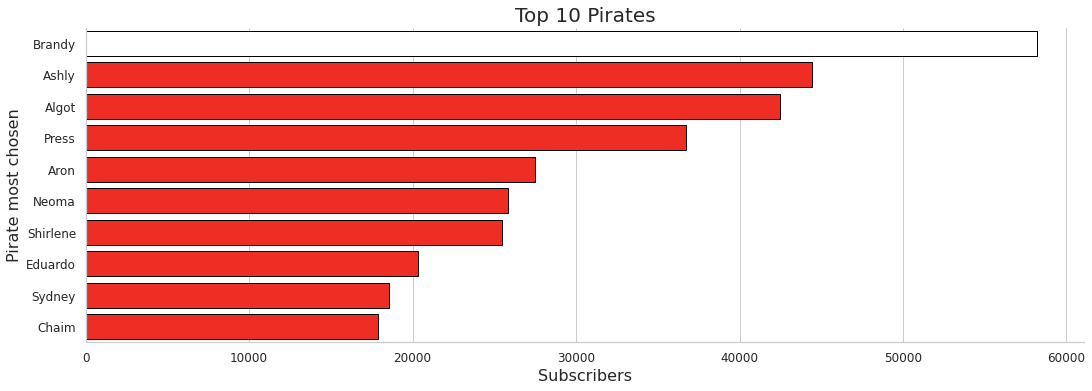

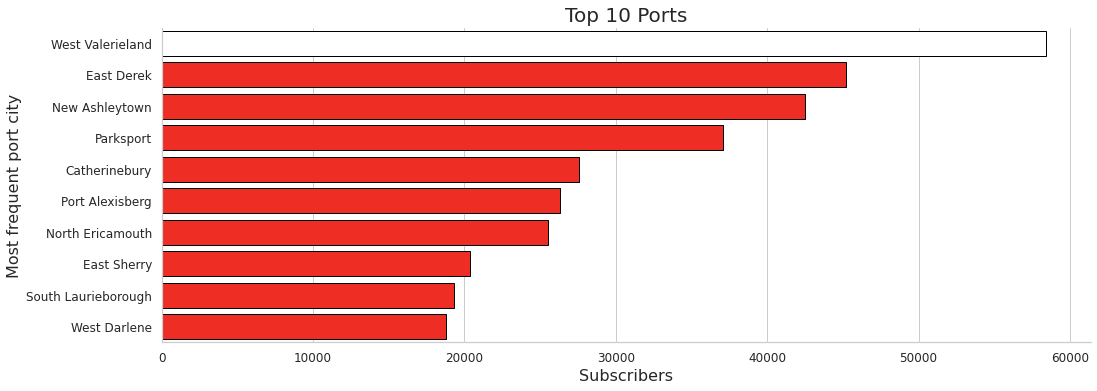

In [17]:
clrs1 = ['#ffffff' if (x == "Brandy")
         else '#EE2E24' for x in data["PIRATE"].value_counts().iloc[0:10].index]
sns.catplot(y="PIRATE", kind="count", palette=clrs1, alpha=1, data=data,
              order=data.PIRATE.value_counts().iloc[0:10].index, height=5, aspect=3, saturation=1, edgecolor="black")
plt.xlabel('Subscribers', size=16)
plt.ylabel('Pirate most chosen', size=16)
plt.title('Top 10 Pirates', size=20)
plt.xticks(size=12)
plt.yticks(size=12)
#plt.savefig('top10pirates.png', dpi=300, bbox_inches='tight')
plt.show()
None

clrs2 = ['#ffffff' if (x == "West Valerieland")
         else '#EE2E24' for x in data["PORTCITY"].value_counts().iloc[0:10].index]
sns.catplot(y="PORTCITY", kind="count", palette=clrs2, alpha=1, data=data,
              order=data.PORTCITY.value_counts().iloc[0:10].index, height=5, aspect=3, saturation=1, edgecolor="black")
plt.xlabel('Subscribers', size=16)
plt.ylabel('Most frequent port city', size=16)
plt.title('Top 10 Ports', size=20)
plt.xticks(size=12)
plt.yticks(size=12)
#plt.savefig('top10ports.png', dpi=300, bbox_inches='tight')
plt.show()
None

In [18]:
print("The top 10 subscribers' choice of space pirate aligns closely with the top 10 top port cities, which is to be expected.")

The top 10 subscribers' choice of space pirate aligns closely with the top 10 top port cities, which is to be expected.


### Missing data

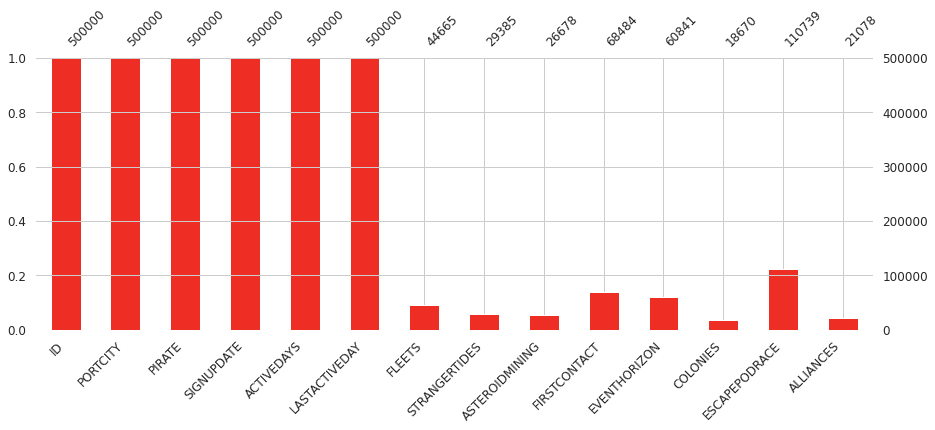

In [19]:
msno.bar(data, color="#EE2E24", figsize=(15, 5), fontsize=12)
#plt.savefig('missingvalues.png', dpi=300, bbox_inches='tight')
None

# Part 1: Intuitive Segmentation

As I progress through the data exploration and preparation, intuitive segments are generated as new columns. 
These columns start with **S[1-7]_**

There is a second notebook in which I did clustering using KNN. Spoiler: The segments shown here are more useful.

In [20]:
data.columns

Index(['ID', 'PORTCITY', 'PIRATE', 'SIGNUPDATE', 'ACTIVEDAYS', 'LASTACTIVEDAY',
       'FLEETS', 'STRANGERTIDES', 'ASTEROIDMINING', 'FIRSTCONTACT',
       'EVENTHORIZON', 'COLONIES', 'ESCAPEPODRACE', 'ALLIANCES'],
      dtype='object')

## S1: Power players

For this segmentation, I consider a power player whose ACTIVEDAYS per days active (SIGNUPDATE to LASTDAYACTIVE) are in the top 20% of the dataset.

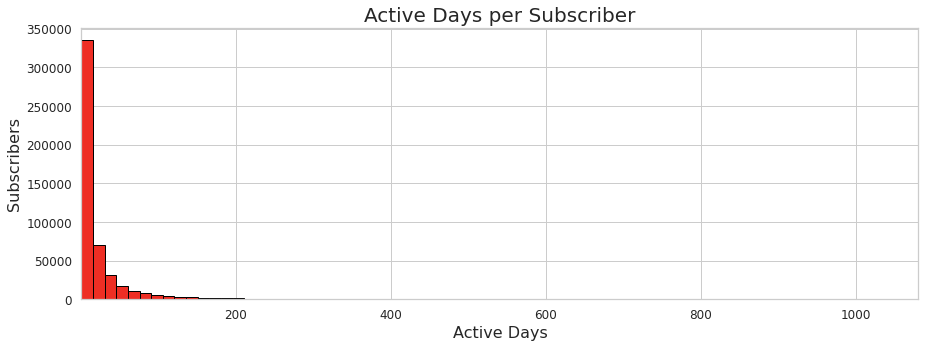

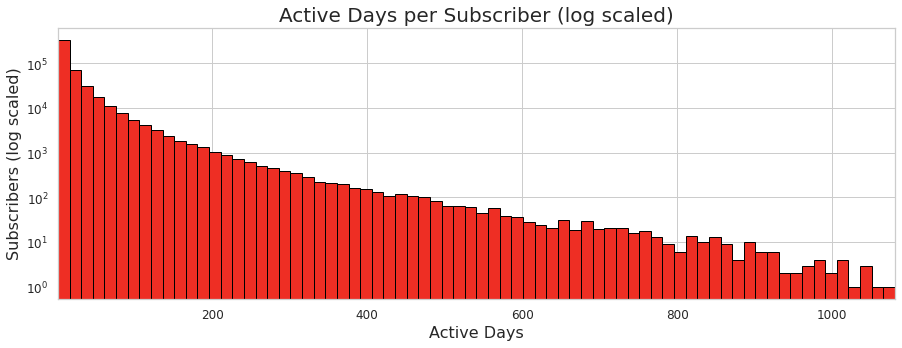

In [21]:
fig = plt.figure(figsize=(15, 5))

plt.margins(x=0)

sns.histplot(data=data, x="ACTIVEDAYS", binwidth=15,
             color="#EE2E24", alpha=1, pmax=1, edgecolor="black")

plt.xlabel('Active Days', size=16)
plt.ylabel('Subscribers', size=16)
plt.title('Active Days per Subscriber', size=20)
plt.xticks(size=12)
plt.yticks(size=12)
#plt.savefig('activedays.png', dpi=300, bbox_inches='tight')
plt.show()

None

# log scaled
fig = plt.figure(figsize=(15, 5))

plt.margins(x=0)

g = sns.histplot(data=data, x="ACTIVEDAYS", binwidth=15,
                 color="#EE2E24", alpha=1, pmax=1, edgecolor="black")

plt.xlabel('Active Days', size=16)
plt.ylabel('Subscribers (log scaled)', size=16)
plt.title('Active Days per Subscriber (log scaled)', size=20)
plt.xticks(size=12)
plt.yticks(size=12)
g.set_yscale('log')
#plt.savefig('activedays_log.png', dpi=300, bbox_inches='tight')
plt.show()

None

In [22]:
print("The vast majority of players can be considered casual players as seen in the graphs above.\nThe median active days are " +
      str(round(data["ACTIVEDAYS"].median(), 1)) + " days, and looking at the mean of " + 
      str(round(data["ACTIVEDAYS"].mean(), 1)) + 
      " days shows how skewed the data is.")

The vast majority of players can be considered casual players as seen in the graphs above.
The median active days are 8.0 days, and looking at the mean of 23.6 days shows how skewed the data is.


**Calculations**

\begin{equation*}
ACTIVITY=\frac{ACTIVEDAYS}{LASTACTIVEDAY.days-INSTALLDATE.days}
\end{equation*}

followed by the top 20% = POWER

(Players who only played once on their first day are excluded, NaN)

In [23]:
data.columns

Index(['ID', 'PORTCITY', 'PIRATE', 'SIGNUPDATE', 'ACTIVEDAYS', 'LASTACTIVEDAY',
       'FLEETS', 'STRANGERTIDES', 'ASTEROIDMINING', 'FIRSTCONTACT',
       'EVENTHORIZON', 'COLONIES', 'ESCAPEPODRACE', 'ALLIANCES'],
      dtype='object')

In [24]:
data["ACTIVITY"] = data['ACTIVEDAYS']/(((data['LASTACTIVEDAY']-data['SIGNUPDATE']).dt.days))

In [25]:
print("There are " + str(data["ACTIVITY"].isna().sum()) + 
      " players who only played one day.\nThose are " + str(round(data["ACTIVITY"].isna().sum()/len(data)*100, 1)) + "% of all players.")

There are 55976 players who only played one day.
Those are 11.2% of all players.


In [26]:
data["ACTIVITY"].quantile(0.8)

0.53125

In [27]:
data["S1_POWER"] = np.where(((data['ACTIVITY'] >= data["ACTIVITY"].quantile(0.8)) & 
                         (data['ACTIVITY'].isna() == False) ) 
                       , 1, 0)

In [28]:
print("There are " + str(len(data[data['S1_POWER'] == 1])) + 
      " power players who, on average, played about every other day (" +
      str(data["ACTIVITY"].quantile(0.8)) +
      ").\nThis corresponds to " + 
      str(round(len(data[data['S1_POWER'] == 1])/len(data)*100, 1)) + "% of all players, not counting the one-day-wonders.")

There are 88827 power players who, on average, played about every other day (0.53125).
This corresponds to 17.8% of all players, not counting the one-day-wonders.


In [29]:
data["S1_POWER"].head()

0    0
1    1
2    1
3    0
4    0
Name: S1_POWER, dtype: int64

## S2: Trial Users

Some players might be only using the free trial (pirate Brandy, port West Valerieland).

For the sake of the argument, I decided that these players will probably only play 1 day to get an idea of the game before deciding whether to subscribe to it or move on. The trial also does not seem to include loading/saving.

In [30]:
data["S2_DEMO"] = np.where(((data['PIRATE'] == 'Brandy') & 
                         (data['PORTCITY'] == 'West Valerieland' ) & 
                         (data['ACTIVEDAYS'] <= 1)) 
                       , 1, 0)

In [31]:
print("There are " + str(len(data[data['S2_DEMO'] == 1])) + 
      " players who are likely demo players.\nThis corresponds to " + 
      str(round(len(data[data['S2_DEMO'] == 1])/len(data)*100, 1)) + "% of all players.")

There are 5626 players who are likely demo players.
This corresponds to 1.1% of all players.


## S3: Active Players

These players have played the game within the last month of the most recent date.

**Calculation**

\begin{equation*}
RECENCY=(data.LASTACTIVEDAY.max().date()-1 month <= LASTACTIVEDAY)
\end{equation*}

where a player is considered active if they played within the last 1 month of the most recent record.

In [32]:
data["RECENCY"] = data.LASTACTIVEDAY.max().date()- dateutil.relativedelta.relativedelta(months=1)
data["RECENCY"]=data["RECENCY"].astype('datetime64')

In [33]:
data["S3_ACTIVE"] = pd.Series(np.where(data['LASTACTIVEDAY'] >= data["RECENCY"], 1, 0), index=data.index)

In [34]:
data["S3_ACTIVE"].head()

0    0
1    0
2    0
3    1
4    0
Name: S3_ACTIVE, dtype: int64

In [35]:
print("There are " + str(len(data[data['S3_ACTIVE'] == 1])) + 
      " players who were active in the month before the most recent date.\nThis corresponds to " + 
      str(round(len(data[data['S3_ACTIVE'] == 1])/len(data)*100, 1)) + "% of all players.")

There are 73837 players who were active in the month before the most recent date.
This corresponds to 14.8% of all players.


## S4: Loyal Players

In [36]:
data.columns

Index(['ID', 'PORTCITY', 'PIRATE', 'SIGNUPDATE', 'ACTIVEDAYS', 'LASTACTIVEDAY',
       'FLEETS', 'STRANGERTIDES', 'ASTEROIDMINING', 'FIRSTCONTACT',
       'EVENTHORIZON', 'COLONIES', 'ESCAPEPODRACE', 'ALLIANCES', 'ACTIVITY',
       'S1_POWER', 'S2_DEMO', 'RECENCY', 'S3_ACTIVE'],
      dtype='object')

Subscribers are considered loyal if they have bought at least one add-on.

In [37]:
addon = ['FLEETS', 'STRANGERTIDES', 'ASTEROIDMINING', 'FIRSTCONTACT',
       'EVENTHORIZON', 'COLONIES', 'ESCAPEPODRACE', 'ALLIANCES']

data["ADDCOUNT"] = data[addon].count(axis=1)

In [38]:
data["S4_LOYAL"] = np.where(((data['ADDCOUNT'] >= 1) ) 
                       , 1, 0)

In [39]:
print(data.groupby('ADDCOUNT')['ID'].nunique())

data.sort_values("ADDCOUNT", ascending=False).head()

ADDCOUNT
0    300896
1    110191
2     47032
3     17588
4     10230
5      6311
6      4472
7      2026
8      1254
Name: ID, dtype: int64


,ID,PORTCITY,PIRATE,SIGNUPDATE,ACTIVEDAYS,LASTACTIVEDAY,FLEETS,STRANGERTIDES,ASTEROIDMINING,FIRSTCONTACT,...,COLONIES,ESCAPEPODRACE,ALLIANCES,ACTIVITY,S1_POWER,S2_DEMO,RECENCY,S3_ACTIVE,ADDCOUNT,S4_LOYAL
316988,316988,New Ashleytown,Algot,2017-06-12,112,2020-02-22,2017-06-12,2017-06-12,2017-06-12,2019-07-02,...,2017-06-12,2018-06-26,2017-06-12,0.113706,0,0,2020-01-22,1,8,1
220342,220342,West Andrewbury,Arline,2018-03-26,71,2019-11-04,2018-03-26,2018-03-26,2018-03-26,2019-07-16,...,2018-03-26,2018-06-27,2018-03-26,0.120748,0,0,2020-01-22,0,8,1
457139,457139,New Ashleytown,Algot,2017-03-27,49,2020-02-03,2017-03-27,2017-03-27,2017-03-27,2019-07-01,...,2017-03-27,2019-02-05,2017-03-27,0.046980,0,0,2020-01-22,1,8,1
59844,59844,New Kathleenport,Else,2019-07-03,66,2020-02-13,2019-07-03,2019-07-03,2019-07-03,2020-01-10,...,2019-07-03,2019-07-03,2019-07-03,0.293333,0,0,2020-01-22,1,8,1
14572,14572,West Steven,Ahmad,2017-03-06,120,2020-02-15,2017-03-06,2017-03-06,2017-03-06,2019-07-01,...,2017-03-06,2018-12-03,2017-03-06,0.111524,0,0,2020-01-22,1,8,1


In [40]:
print("There are " + str(len(data[data['S4_LOYAL'] == 1])) + 
      " players who own at least 1 out of the 8 add-ons of the game.\nThis corresponds to " + 
      str(round(len(data[data['S4_LOYAL'] == 1])/len(data)*100, 1)) + "% of all players.\nA total of " + 
      str(data["ADDCOUNT"].sum()) + " add-ons were bought and "+
     str(len(data[data['ADDCOUNT'] == 8])) +
      " players have bought all 8 of them."
     )

There are 199104 players who own at least 1 out of the 8 add-ons of the game.
This corresponds to 39.8% of all players.
A total of 380540 add-ons were bought and 1254 players have bought all 8 of them.


## S5: Modding

In the original task, this section included fuzzy matching using the fuzzywuzzy library and external sources. For simplicity, this section is omitted here resulting in **S5_Modders** being missing in the evaluation.

### List of Original Pirates and Port Cities

### Fuzzy Matching with Pirates/Cities in Dataset; Removing Possible Mods

### Get Players using Mods

## S6: Early Adopters

In this category players who started playing within the first month of the game's official release are found.

**Calculation**

\begin{equation*}
EARLY=(data.INSTALLDATE.date()<= release date + 15 days)
\end{equation*}

In [41]:
release = dt.datetime(2017, 3,7, 0, 0)

data["EARLY"] = release + dateutil.relativedelta.relativedelta(days=15)
data["EARLY"]=data["EARLY"].astype('datetime64')

In [42]:
data["S6_EARLY"] = pd.Series(np.where(data['SIGNUPDATE'] <= data["EARLY"], 1, 0), index=data.index)

In [43]:
print(data.groupby('S6_EARLY')['ID'].nunique())

data.sort_values("SIGNUPDATE", ascending=True).head()

S6_EARLY
0    408444
1     91556
Name: ID, dtype: int64


,ID,PORTCITY,PIRATE,SIGNUPDATE,ACTIVEDAYS,LASTACTIVEDAY,FLEETS,STRANGERTIDES,ASTEROIDMINING,FIRSTCONTACT,...,ALLIANCES,ACTIVITY,S1_POWER,S2_DEMO,RECENCY,S3_ACTIVE,ADDCOUNT,S4_LOYAL,EARLY,S6_EARLY
1268,1268,Parksport,Press,2017-01-07,41,2020-01-21,NaT,NaT,NaT,2019-08-10,...,NaT,0.036970,0,0,2020-01-22,0,2,1,2017-03-22,1
1271,1271,New Kathleenport,Else,2017-01-08,48,2017-03-24,NaT,NaT,NaT,NaT,...,NaT,0.640000,1,0,2020-01-22,0,0,0,2017-03-22,1
1270,1270,West Andrewbury,Arline,2017-01-08,74,2019-11-02,NaT,NaT,2017-01-08,2019-04-15,...,NaT,0.071984,0,0,2020-01-22,0,2,1,2017-03-22,1
1269,1269,South Laurieborough,Rhona,2017-01-08,6,2017-03-13,NaT,NaT,NaT,NaT,...,NaT,0.093750,0,0,2020-01-22,0,0,0,2017-03-22,1
1273,1273,West Elizabethtown,Ione,2017-01-09,159,2020-02-14,2017-01-09,2017-01-09,2017-01-09,2019-02-11,...,2017-01-09,0.140584,0,0,2020-01-22,1,8,1,2017-03-22,1


In [44]:
print("There are " + str(len(data[data['S6_EARLY'] == 1])) + 
      " players who subscribed to the game within 1 month of its release.\nThis corresponds to " + 
      str(round(len(data[data['S6_EARLY'] == 1])/len(data)*100, 1)) + "% of all players.")

There are 91556 players who subscribed to the game within 1 month of its release.
This corresponds to 18.3% of all players.


## S7: Others

These are all the subscribers that didn't make it into any of the other groups.

Due to S5 being excluded in this notebook, more subscribers ended up in S7 than in the original task.

In [45]:
segments = ['S1_POWER', 'S2_DEMO', 'S3_ACTIVE',
            'S4_LOYAL', 'S6_EARLY']

data["INSEGMENTS"] = data[segments].sum(axis=1)

In [46]:
data["S7_OTHERS"] = np.where(((data['INSEGMENTS'] == 0) ) 
                       , 1, 0)

In [47]:
data["S7_OTHERS"]

0         1
1         0
2         0
3         0
4         0
         ..
499995    1
499996    1
499997    0
499998    0
499999    1
Name: S7_OTHERS, Length: 500000, dtype: int64

In [48]:
print(data.groupby('INSEGMENTS')['ID'].nunique())

data.sort_values("INSEGMENTS", ascending=False).head()

INSEGMENTS
0    168724
1    218837
2     97436
3     14771
4       232
Name: ID, dtype: int64


,ID,PORTCITY,PIRATE,SIGNUPDATE,ACTIVEDAYS,LASTACTIVEDAY,FLEETS,STRANGERTIDES,ASTEROIDMINING,FIRSTCONTACT,...,S1_POWER,S2_DEMO,RECENCY,S3_ACTIVE,ADDCOUNT,S4_LOYAL,EARLY,S6_EARLY,INSEGMENTS,S7_OTHERS
486842,486842,East Derek,Ashly,2017-03-07,697,2020-02-12,NaT,NaT,NaT,2019-07-01,...,1,0,2020-01-22,1,2,1,2017-03-22,1,4,0
69001,69001,North Ericamouth,Shirlene,2017-03-10,1056,2020-02-20,2017-03-10,2017-03-10,2017-03-10,NaT,...,1,0,2020-01-22,1,6,1,2017-03-22,1,4,0
63124,63124,East Derek,Ashly,2017-03-06,763,2020-02-11,NaT,2017-03-06,2017-03-06,2019-07-05,...,1,0,2020-01-22,1,7,1,2017-03-22,1,4,0
325381,325381,West Darlene,Kara,2017-03-08,601,2020-02-22,2017-03-08,2017-03-08,2017-03-08,2019-07-01,...,1,0,2020-01-22,1,7,1,2017-03-22,1,4,0
29220,29220,North Ericamouth,Shirlene,2017-03-09,636,2020-02-22,NaT,NaT,NaT,2019-07-01,...,1,0,2020-01-22,1,3,1,2017-03-22,1,4,0


In [49]:
print("There are still " + str(len(data[data['S7_OTHERS'] == 1])) + 
      " players who can't properly be targeted using the intuitive segmentation approach.\nThis corresponds to " + 
      str(round(len(data[data['S7_OTHERS'] == 1])/len(data)*100, 1)) + "% of all players.\nOn the other hand, " +
     str((len(data))-len(data[data['INSEGMENTS'] <2])) +
      " players, or " + str(
          round(
              (len(data)-len(data[data['INSEGMENTS'] < 2]))/len(data)*100, 1)) +
      "% of all players are in 2 or more segments."
     )

There are still 168724 players who can't properly be targeted using the intuitive segmentation approach.
This corresponds to 33.7% of all players.
On the other hand, 112439 players, or 22.5% of all players are in 2 or more segments.


## Summary of Segments

In [50]:
segments = ['S1_POWER', 'S2_DEMO', 'S3_ACTIVE', 'S4_LOYAL', 'S6_EARLY', 'S7_OTHERS']

In [51]:
segment=data[segments].apply(pd.value_counts)
segment.reindex([1,0])
segment.rename(index={1:'IN', 0: 'OUT'}, inplace=True)

In [52]:
segment

,S1_POWER,S2_DEMO,S3_ACTIVE,S4_LOYAL,S6_EARLY,S7_OTHERS
OUT,411173,494374,426163,300896,408444,331276
IN,88827,5626,73837,199104,91556,168724


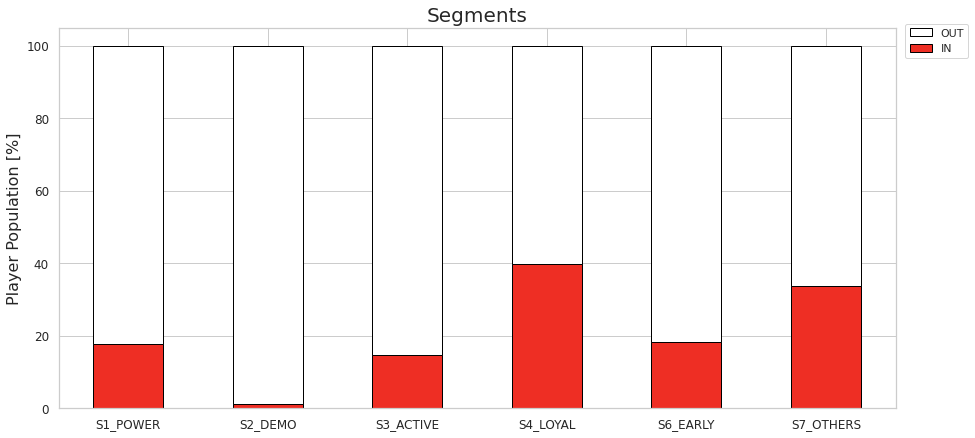

In [53]:
cmap = ['#EE2E24', '#ffffff']

ax = segment.transpose().apply(lambda x: 100-(x*100/sum(x)), axis=1).plot(kind="bar", figsize=(15, 7),
                                                                          stacked=True, rot=0, edgecolor="black",color=cmap )

plt.xlabel('', size=16)
plt.ylabel('Player Population [%]', size=16)
plt.title('Segments', size=20)
plt.xticks(size=12)
plt.yticks(size=12)

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), labels, bbox_to_anchor=(
    1.005, 1.025), loc='upper left')
#plt.savefig('segments.png', dpi=300, bbox_inches='tight')

plt.show()
None

# Part 2: Machine Learning: Clustering with K-Means

Make a copy of the data and set the ID as index

In [54]:
data_copy = data.copy()

In [55]:
# remove previously defined segments and some helping metrics
data_copy.drop(columns=['RECENCY', 'EARLY', 'INSEGMENTS', "S1_POWER",  "S2_DEMO",
                        "S3_ACTIVE", "S4_LOYAL", "S6_EARLY", "S7_OTHERS"], inplace=True)

In [56]:
data_copy.dtypes

ID                         int64
PORTCITY                  object
PIRATE                    object
SIGNUPDATE        datetime64[ns]
ACTIVEDAYS                 int64
LASTACTIVEDAY     datetime64[ns]
FLEETS            datetime64[ns]
STRANGERTIDES     datetime64[ns]
ASTEROIDMINING    datetime64[ns]
FIRSTCONTACT      datetime64[ns]
EVENTHORIZON      datetime64[ns]
COLONIES          datetime64[ns]
ESCAPEPODRACE     datetime64[ns]
ALLIANCES         datetime64[ns]
ACTIVITY                 float64
ADDCOUNT                   int64
dtype: object

In [57]:
data_copy.head()

,ID,PORTCITY,PIRATE,SIGNUPDATE,ACTIVEDAYS,LASTACTIVEDAY,FLEETS,STRANGERTIDES,ASTEROIDMINING,FIRSTCONTACT,EVENTHORIZON,COLONIES,ESCAPEPODRACE,ALLIANCES,ACTIVITY,ADDCOUNT
0,0,New Kathleenport,Else,2018-05-22,1,2018-05-22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaN,0
1,1,New Ashleytown,Algot,2018-05-22,3,2018-05-26,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,0.750000,0
2,2,East Derek,Ashly,2018-05-22,115,2018-11-22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,0.625000,0
3,3,Catherinebury,Aron,2018-07-19,112,2020-02-19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,0.193103,0
4,4,Ambershire,Mansfield,2018-07-27,1,2018-07-27,NaT,NaT,2018-07-27,NaT,NaT,NaT,NaT,NaT,NaN,1


In [58]:
# set activity NaN == 0

data_copy["ACTIVITY"]=data_copy["ACTIVITY"].fillna(0)

## Transform and Encode Features

In [59]:
# get columns with numerical values, time values, and categorical values
cat_cols_data = data_copy.select_dtypes(include=['object']).columns
numer_cols_data = data_copy.select_dtypes(include=['int', 'float']).columns
time_cols_data = data_copy.select_dtypes(include=['datetime64[ns]']).columns

In [60]:
cat_cols_data

Index(['PORTCITY', 'PIRATE'], dtype='object')

### Dates to Binary (Presence, Absence)

In [61]:
data_copy[time_cols_data] = np.where(((data_copy[time_cols_data].isna() == False) ) 
                       , 1, 0)

In [62]:
data_copy[time_cols_data]

,SIGNUPDATE,LASTACTIVEDAY,FLEETS,STRANGERTIDES,ASTEROIDMINING,FIRSTCONTACT,EVENTHORIZON,COLONIES,ESCAPEPODRACE,ALLIANCES
0,1,1,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,0
4,1,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
499995,1,1,0,0,0,0,0,0,0,0
499996,1,1,0,0,0,0,0,0,0,0
499997,1,1,0,0,0,0,0,0,0,0
499998,1,1,0,0,0,0,0,0,0,0


### Scale numerical columns

In [63]:
numer_cols_data

Index(['ID', 'ACTIVEDAYS', 'ACTIVITY', 'ADDCOUNT'], dtype='object')

In [64]:
data_copy[numer_cols_data].isna().sum().sum()

0

In [65]:
scaler = MinMaxScaler()
data_copy[numer_cols_data]=scaler.fit_transform(data_copy[numer_cols_data])
data_copy[numer_cols_data]=pd.DataFrame(data=data_copy[numer_cols_data], columns=data_copy[numer_cols_data].columns)

In [66]:
data_copy[numer_cols_data]

,ID,ACTIVEDAYS,ACTIVITY,ADDCOUNT
0,0.000000,0.000000,0.000000,0.000
1,0.000002,0.001852,0.187500,0.000
2,0.000004,0.105556,0.156250,0.000
3,0.000006,0.102778,0.048276,0.000
4,0.000008,0.000000,0.000000,0.125
...,...,...,...,...
499995,0.999992,0.009259,0.004816,0.000
499996,0.999994,0.000926,0.005376,0.000
499997,0.999996,0.002778,0.142857,0.000
499998,0.999998,0.004630,0.214286,0.000


In [67]:
#scaler.inverse_transform(data_copy[numer_cols_data])

### One-Hot Encode Categorical Features
This creates a binary column for each category and returns a sparse matrix or dense array.

This part uses quite a lot of memory.

In [68]:
data_copy[cat_cols_data].columns

Index(['PORTCITY', 'PIRATE'], dtype='object')

In [69]:
ohe = OneHotEncoder()

# fit data
ohe.fit(data_copy[cat_cols_data])

ohe.categories_

[array(['Aaronfurt', 'Adamhaven', 'Adamston', 'Adrienneside', 'Alanshire',
        'Alexisberg', 'Alexishaven', 'Alexisshire', 'Allenchester',
        'Amberburgh', 'Ambershire', 'Amberton', 'Andersonbury',
        'Andreafurt', 'Ashleyburgh', 'Avilamouth', 'Bairdborough',
        'Benderside', 'Blankenshipfort', 'Bowmanfort', 'Boydmouth',
        'Brenthaven', 'Brianview', 'Bruceberg', 'Bushview', 'Cameronstad',
        'Campbellfort', 'Carlsonside', 'Carolynmouth', 'Carpenterburgh',
        'Carterchester', 'Catherinebury', 'Charlesshire', 'Charlesview',
        'Chaseside', 'Cherylbury', 'Christianberg', 'Christinemouth',
        'Christopherville', 'Chungmouth', 'Clarkfurt', 'Codytown',
        'Colliershire', 'Colonfurt', 'Connieland', 'Cookport', 'Coxshire',
        'Cruzburgh', 'Cynthiatown', 'Danaside', 'Davidchester',
        'Davidport', 'Davidside', 'Davisfurt', 'Davishaven', 'Denisetown',
        'Derekview', 'Desireeview', 'Destinyberg', 'Douglasshire',
        'East Alexa

In [70]:
data_transf = ohe.transform(data_copy[cat_cols_data]).toarray()
data_transf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [71]:
transform_col_name = ohe.get_feature_names()
transform_col_name

array(['x0_Aaronfurt', 'x0_Adamhaven', 'x0_Adamston', ..., 'x1_Yoel',
       'x1_Zelda', 'x1_Zillah'], dtype=object)

In [72]:
trans_cat_df = pd.DataFrame(data_transf, columns=transform_col_name)

In [73]:
trans_cat_df

,x0_Aaronfurt,x0_Adamhaven,x0_Adamston,x0_Adrienneside,x0_Alanshire,x0_Alexisberg,x0_Alexishaven,x0_Alexisshire,x0_Allenchester,x0_Amberburgh,...,x1_Wendell,x1_Willodean,x1_Windell,x1_Winston,x1_Yair,x1_Yamilet,x1_Yancy,x1_Yoel,x1_Zelda,x1_Zillah
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
499996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
499997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
499998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Remove highly correlated OHE features


In [74]:
# loop to get the columns with highly correlated features

drop_final = set()
for i in range(len(trans_cat_df.columns)):
    for j in range(i):
        # this number could be lower or higher, depending on the data and number of features
        if abs(trans_cat_df.iloc[i, j]) > 0.85:
            colname = trans_cat_df.columns[i]
            drop_final.add(colname)
drop_final

{'x0_Derekview',
 'x0_East Joshua',
 'x0_East Lisa',
 'x0_East Michelleport',
 'x0_East Zacharyburgh',
 'x0_Fullerland',
 'x0_Gabrielview',
 'x0_Garciahaven',
 'x0_Garrettport',
 'x0_Hopkinsberg',
 'x0_Howardfort',
 'x0_Jasonburgh',
 'x0_Jenniferport',
 'x0_Johnsonside',
 'x0_Jonesbury',
 'x0_Jordanfurt',
 'x0_Karenhaven',
 'x0_Kathyborough',
 'x0_Lake Brandy',
 'x0_Lake Jacobburgh',
 'x0_Lake Jordanhaven',
 'x0_Lake Michaelahaven',
 'x0_Lake Molly',
 'x0_Leblancside',
 'x0_Lesliemouth',
 'x0_Liuland',
 'x0_Lynnmouth',
 'x0_Martinezmouth',
 'x0_Meganland',
 'x0_Monicaport',
 'x0_New Angelaberg',
 'x0_New Carlaburgh',
 'x0_New Catherineborough',
 'x0_New James',
 'x0_New Jennifer',
 'x0_New Jessica',
 'x0_New Kristi',
 'x0_New Michael',
 'x0_New Reginashire',
 'x0_New Ryanmouth',
 'x0_Nguyenchester',
 'x0_Nicoleshire',
 'x0_Noahburgh',
 'x0_North Brent',
 'x0_North Charlesstad',
 'x0_North Ericbury',
 'x0_North Jermaineland',
 'x0_North Mark',
 'x0_North Michaelside',
 'x0_North Nathanm

In [75]:
len(drop_final)

857

In [76]:
trans_cat_df=trans_cat_df.drop(columns=drop_final)

In [77]:
trans_cat_df

,x0_Aaronfurt,x0_Adamhaven,x0_Adamston,x0_Adrienneside,x0_Alanshire,x0_Alexisberg,x0_Alexishaven,x0_Alexisshire,x0_Allenchester,x0_Amberburgh,...,x0_Summersville,x0_Tammyhaven,x0_Terristad,x0_Tonimouth,x0_Turnerville,x0_Vargasbury,x0_West Amandaland,x0_West Elizabethtown,x0_West Patriciaberg,x0_West Valerieland
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
499996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
499997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
499998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
trans_cat_df["ID"]=data.index

trans_cat_df.set_index('ID', inplace=True)
trans_cat_df.head()

,x0_Aaronfurt,x0_Adamhaven,x0_Adamston,x0_Adrienneside,x0_Alanshire,x0_Alexisberg,x0_Alexishaven,x0_Alexisshire,x0_Allenchester,x0_Amberburgh,...,x0_Summersville,x0_Tammyhaven,x0_Terristad,x0_Tonimouth,x0_Turnerville,x0_Vargasbury,x0_West Amandaland,x0_West Elizabethtown,x0_West Patriciaberg,x0_West Valerieland
ID,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Put everything back together

In [79]:
data_transf = pd.concat([trans_cat_df, data_copy[numer_cols_data], data_copy[time_cols_data]], axis=1)

In [80]:
data_transf

,x0_Aaronfurt,x0_Adamhaven,x0_Adamston,x0_Adrienneside,x0_Alanshire,x0_Alexisberg,x0_Alexishaven,x0_Alexisshire,x0_Allenchester,x0_Amberburgh,...,SIGNUPDATE,LASTACTIVEDAY,FLEETS,STRANGERTIDES,ASTEROIDMINING,FIRSTCONTACT,EVENTHORIZON,COLONIES,ESCAPEPODRACE,ALLIANCES
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,0,0,0,0,0,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,0,0,0,0,0,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,0,0,0,0,0,0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,0,0,0,0,0,0,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,0,0,0,0,0,0,0,0
499996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,0,0,0,0,0,0,0,0
499997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,0,0,0,0,0,0,0,0
499998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,0,0,0,0,0,0,0,0


## Clustering

### Find best number for K with a data sample

In [81]:
sample= data_transf.sample(frac=0.1, replace=False, random_state=13)

In [82]:
len(sample)

50000

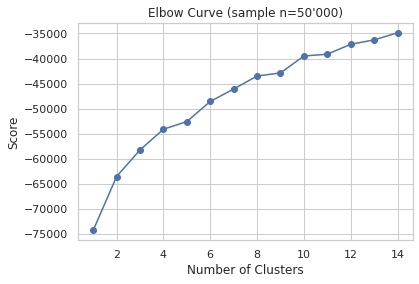

In [83]:
Nc = range(1, 15)

kmeans = [KMeans(n_clusters=i) for i in Nc]

score = [kmeans[i].fit(sample).score(sample) for i in range(len(kmeans))]

score

plt.plot(Nc,score, marker='o')

plt.xlabel('Number of Clusters')

plt.ylabel('Score')

plt.title("Elbow Curve (sample n=50'000)")

plt.show()

### Find best number for K with the full data set

This takes a bit longer and is quite unnecessary. 

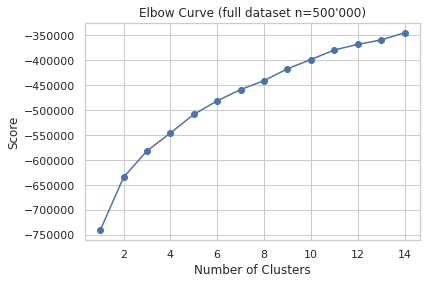

In [84]:
# takes ~ 10mins to run
Nc = range(1, 15)

kmeans = [KMeans(n_clusters=i) for i in Nc]

score = [kmeans[i].fit(data_transf).score(data_transf) for i in range(len(kmeans))]

score

plt.plot(Nc,score, marker='o') 

plt.xlabel('Number of Clusters')

plt.ylabel('Score')

plt.title("Elbow Curve (full dataset n=500'000)")

plt.show()

In [85]:
print("Looking at the above graphs, using a random sample of 10% of the data led to the identification of k=6.\nUsing the whole dataset did not change this finding."
     )

Looking at the above graphs, using a random sample of 10% of the data led to the identification of k=6.
Using the whole dataset did not change this finding.


### Run k-means, k=6

In [86]:
kmeans_all = KMeans(n_clusters=6, init="k-means++", n_init=10, 
                  verbose=1, random_state=13, copy_x=True, n_jobs=-1, algorithm="auto").fit(data_transf)

Initialization complete
Iteration 0, inertia 629116.1686942448
Iteration 1, inertia 523644.7487043119
Iteration 2, inertia 512144.5902716334
Iteration 3, inertia 510228.0547266967
Iteration 4, inertia 510066.9753302499
Iteration 5, inertia 509883.16129801667
Iteration 6, inertia 509561.5582074527
Iteration 7, inertia 509397.51609543734
Iteration 8, inertia 509325.234097224
Iteration 9, inertia 509283.3317018796
Iteration 10, inertia 509249.88343679206
Iteration 11, inertia 509217.22281136387
Iteration 12, inertia 509180.0022276341
Iteration 13, inertia 509133.43567756074
Iteration 14, inertia 509072.0325508666
Iteration 15, inertia 508986.11674504384
Iteration 16, inertia 508867.7013644441
Iteration 17, inertia 508674.49948373827
Iteration 18, inertia 508332.45070670743
Iteration 19, inertia 508054.17977022287
Iteration 20, inertia 507731.1180214632
Iteration 21, inertia 507518.8317568197
Iteration 22, inertia 507502.78911572957
Iteration 23, inertia 507488.93272113
Iteration 24, inert

In [87]:
kmeans_all.cluster_centers_

array([[-1.24937360e-19,  1.07064965e-18, -1.24937360e-19, ...,
         1.37264457e-02,  1.24891705e-01,  1.11002816e-02],
       [-8.13998662e-19,  3.58911779e-05,  3.58911779e-06, ...,
         1.85377934e-02, -1.58428826e-13,  1.71631613e-02],
       [-1.62630326e-19,  1.25360876e-18, -1.62630326e-19, ...,
         1.79357962e-02,  1.32792350e-01,  2.93043927e-02],
       [-1.14349448e-19,  2.90393774e-05, -1.14349448e-19, ...,
         7.89871065e-02,  1.36456034e-01,  9.11546056e-02],
       [-3.76929662e-20,  6.53909435e-19, -3.76929662e-20, ...,
         3.12891772e-01,  7.86437558e-01,  3.72200061e-01],
       [ 1.30220202e-05,  2.60440405e-05,  1.25360876e-19, ...,
         2.91172372e-02,  1.00000000e+00,  3.61881942e-02]])

In [88]:
kmeans_all.labels_

array([1, 0, 1, ..., 2, 1, 1], dtype=int32)

In [89]:
data_copy["KNNCLUSTER"]=kmeans_all.labels_

In [90]:
data_copy.columns

Index(['ID', 'PORTCITY', 'PIRATE', 'SIGNUPDATE', 'ACTIVEDAYS', 'LASTACTIVEDAY',
       'FLEETS', 'STRANGERTIDES', 'ASTEROIDMINING', 'FIRSTCONTACT',
       'EVENTHORIZON', 'COLONIES', 'ESCAPEPODRACE', 'ALLIANCES', 'ACTIVITY',
       'ADDCOUNT', 'KNNCLUSTER'],
      dtype='object')

## Merge results with data

In [91]:
data = pd.merge(data, data_copy["KNNCLUSTER"],  left_index=True, right_index=True)

In [92]:
data.columns

Index(['ID', 'PORTCITY', 'PIRATE', 'SIGNUPDATE', 'ACTIVEDAYS', 'LASTACTIVEDAY',
       'FLEETS', 'STRANGERTIDES', 'ASTEROIDMINING', 'FIRSTCONTACT',
       'EVENTHORIZON', 'COLONIES', 'ESCAPEPODRACE', 'ALLIANCES', 'ACTIVITY',
       'S1_POWER', 'S2_DEMO', 'RECENCY', 'S3_ACTIVE', 'ADDCOUNT', 'S4_LOYAL',
       'EARLY', 'S6_EARLY', 'INSEGMENTS', 'S7_OTHERS', 'KNNCLUSTER'],
      dtype='object')

# Visualizations of Clusters

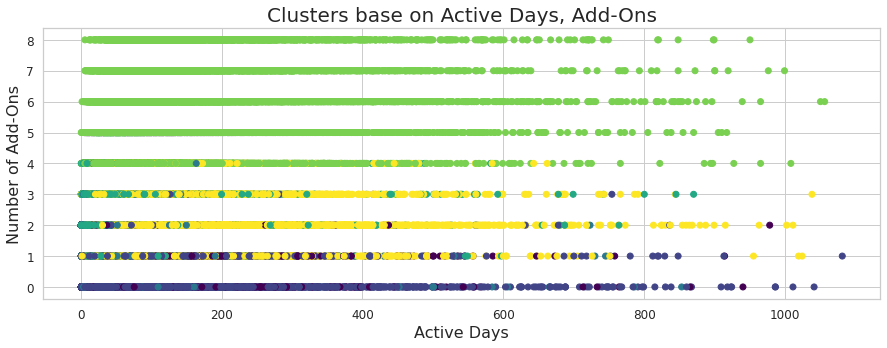

In [93]:
fig = plt.figure(figsize=(15, 5))

plt.scatter(data["ACTIVEDAYS"], 
            data["ADDCOUNT"]
            , c=data["KNNCLUSTER"], cmap='viridis')
plt.xticks(size=12)
plt.yticks(size=12)
plt.title("Clusters base on Active Days, Add-Ons", size=20)
plt.xlabel("Active Days", size=16)
plt.ylabel("Number of Add-Ons", size=16)
None

In [94]:
print("One of the ways KNN divided the subscribers is based on the number of purchased add-ons.\nSubscribers owning 4 or more of them were mostly grouped together."
     )
print("Subscribers owning 1 appear together and so do players not owning any. Those owning 2-3 are distributed roughlty into 2 clusters.")

One of the ways KNN divided the subscribers is based on the number of purchased add-ons.
Subscribers owning 4 or more of them were mostly grouped together.
Subscribers owning 1 appear together and so do players not owning any. Those owning 2-3 are distributed roughlty into 2 clusters.


In [95]:
now = datetime.now()

dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
print("END =", dt_string)

END = 01/07/2021 17:10:42
